In [1]:
#import numpy as np
#import matplotlib.pyplot as plt
import yaml, sys #os, sys, yaml
sys.path.insert(0,'../')
#import StatPol as SP, 
from Routines import AuToA #import Routines as R
#basepath = os.getcwd()

# Data to be analyzed
We construct various dictionaries with the results provided by Qchem (`HG_data`),
the results from MRChem (`MW_data`) and the data from PSP calculations (`BG_data`).
The latter is a dictionary with a further level indicating the family of the PSP chosen for the study. We also indicate, for each of the dataset, the molecules that are missing in the other reference data.

## Load reference data from HG supplementary information

In [2]:
HG_data=yaml.load(open('../HG Dataset/hg_data.yaml'))
# set the study for H to sp
HG_data['H']['spin_pol'] = 'sp'

In [3]:
HG_data['BF']

{'CCSD(T)': [2.95, 2.95, 2.686],
 'field_int': 0.01,
 'lda-SPW92': [3.315, 3.315, 2.991],
 'lda-Slater': [3.603, 3.603, 3.27],
 'mpol_ref': '1',
 'pbe': [3.271, 3.271, 2.974],
 'pbe0': [3.159, 3.159, 2.78],
 'spin_pol': 'nsp'}

Distinguish between closed shell and open shell molecules

In [4]:
open_shell=[mol for mol in HG_data if HG_data[mol]['spin_pol'] == 'sp']
closed_shell=[mol for mol in HG_data if HG_data[mol]['spin_pol'] == 'nsp']

## Load Multiwavelet data with finite-differences

In [5]:
MWdata=yaml.load(open('../mw_data_0001v2.yaml'))
MW_data={mol:{xcref: MWdata[mol][xc]['diagonal'] for xcref,xc in [('lda-SPW92','lda'),('pbe','pbe')]} for mol in MWdata}

In [6]:
MW_data['co']

{'lda-SPW92': [1.868431750384668, 1.8684317500142003, 2.3535110461925104],
 'pbe': [1.8532465936431202, 1.8532465936431202, 2.359389168196766]}

Find the data which are not present in the MW dictionary

In [7]:
MW_missing=set()
for mol in HG_data:
    if mol.lower() not in MW_data:
        print ('Molecule "'+mol+'" not present in MRchem data')
        MW_missing.add(mol)

Molecule "PS" not present in MRchem data
Molecule "CH3O" not present in MRchem data
Molecule "S2" not present in MRchem data
Molecule "SH" not present in MRchem data


## Load PSP data from BigDFT calculations
After loading the data only consider the molecules for which the value of alpha is converged according to the criterion of the Workflow.

In [9]:
def get_field(full_results,study):
    """
    Retrieve the value of the field that provided the tolerance of the options
    """
    tol=full_results['options']['atol']
    field=full_results[study]['alpha_convergence']
    if field is not None: field=field[0]['f']
    return tol,field
def alpha_is_reliable(full_results,study):
    """
    Provide a boolean stating if the given study has a reliable statical polarizability
    """
    tol,field=get_field(full_results,study)
    if field is None or field == 0.0001: return False
    return True

def study_matches(study,key):
    """
    Returns the rest of the tuple of the study
    """
    #case of a string
    if type(key) == type('a'): return [i for i in study if i != key]
    #case of a tuple
    return [i for i in study if i not in list(key)]

def get_result(full_results,study,key):
    null=(None,None,None)
    if study == 'options' or not alpha_is_reliable(full_results,study): return null
    dataname=study_matches(study,key)
    th=2 if type(key) == type('a') else 3-len(key)
    if len(dataname)> th: return null
    result=full_results[study]['alpha_convergence']
    tol,field=get_field(full_results,study)
    return result,dataname,field

def reformat_result(full_results,key):
    """
    Works with a name of a (psp) as key
    """
    res={}
    import numpy
    for study in full_results:
        result,dataname,field = get_result(full_results,study,key)
        if result is None: continue
        alpha=numpy.array(result[1])*AuToA
        st=tuple(dataname)
        mol=st[0]
        xc=st[1] if st[1] != 'lda_pw' else 'lda-SPW92'
        res.setdefault(mol,{})
        res[mol].update({xc:alpha,xc+'-f':field})
    return res

In [10]:
full_results = yaml.load(open('full_results.yaml'))

In [11]:
full_results[('OH','pbe','hgh_k')]

{'alpha_convergence': ({'f': 0.001, 'rmult': 8.0},
  [6.8349435, 6.8349435, 9.32050000000001]),
 'input_gs': {'dft': {'gnrm_cv': 1e-06,
   'hgrids': 0.3,
   'ixc': 11,
   'mpol': 1,
   'nspin': 2,
   'rmult': [5.0, 9.0]}},
 'posinp': {'positions': [{'H': [0.0, 0.0, 0.0], 'frag': ['molecule', '0']},
   {'O': [0.0, 0.0, 0.9697], 'frag': ['molecule', '0']}],
  'units': 'angstroem'}}

In [12]:
# Failed rmult convergence for alpha, inform (this should rather go in the workflow detection nb)
for s in full_results:
    if s == 'options': continue
    tol,field=get_field(full_results,s)
    if field is None: print (s,'not_converged in size')
    if field == 0.0001: print (s,'not converged in field')

(('C2H', 'pbe', 'hgh_k'), 'not_converged in size')
(('CH3O', 'pbe', 'nlcc_ss'), 'not_converged in size')
(('CH3O', 'pbe', 'nlcc_aw'), 'not converged in field')
(('CH3O', 'lda_pw', 'hgh_k'), 'not_converged in size')
(('CH3O', 'pbe0', 'hgh_k'), 'not_converged in size')
(('CH3O', 'pbe', 'hgh_k'), 'not_converged in size')


All the studies with convergence problem are in the open_shell sector of the database

In [13]:
for s in full_results:
    if s[0] in closed_shell:
        tol,field=get_field(full_results,s)
        if field is None: print (s,'not_converged in size')
        if field == 0.0001: print (s,'not converged in field')

Reformat the dictionary of the data per family of PSP

In [14]:
BG_data={}
for psp in ['hgh_k','nlcc_aw','nlcc_ss']:
    BG_data[psp]=reformat_result(full_results,(psp))

In [15]:
BG_data['hgh_k']['CO']

{'lda-SPW92': array([1.87139847, 1.87139847, 2.35082149]),
 'lda-SPW92-f': 0.005,
 'pbe': array([1.85374463, 1.85374463, 2.3569222 ]),
 'pbe-f': 0.005,
 'pbe0': array([1.77981528, 1.77981528, 2.27027629]),
 'pbe0-f': 0.005}

Check which molecules are still missing in the various data

In [16]:
missing={}
for psp in BG_data:
    missing[psp]=set()
    for mol in HG_data:
        if mol not in BG_data[psp]:
            print ('Molecule "'+mol+'" not present in BigDFT data with psp "'+psp+'"')
            missing[psp].add(mol)
BG_missing={'HG':missing}

Molecule "LiH" not present in BigDFT data with psp "nlcc_aw"
Molecule "Be" not present in BigDFT data with psp "nlcc_aw"
Molecule "NaLi" not present in BigDFT data with psp "nlcc_aw"
Molecule "Na" not present in BigDFT data with psp "nlcc_aw"
Molecule "BeH2" not present in BigDFT data with psp "nlcc_aw"
Molecule "He" not present in BigDFT data with psp "nlcc_aw"
Molecule "LiBH4" not present in BigDFT data with psp "nlcc_aw"
Molecule "CH3O" not present in BigDFT data with psp "nlcc_aw"
Molecule "Li2" not present in BigDFT data with psp "nlcc_aw"
Molecule "Ne" not present in BigDFT data with psp "nlcc_aw"
Molecule "NaCN" not present in BigDFT data with psp "nlcc_aw"
Molecule "BeH" not present in BigDFT data with psp "nlcc_aw"
Molecule "H2O-Li" not present in BigDFT data with psp "nlcc_aw"
Molecule "LiCl" not present in BigDFT data with psp "nlcc_aw"
Molecule "Li" not present in BigDFT data with psp "nlcc_aw"
Molecule "NaCl" not present in BigDFT data with psp "nlcc_aw"
Molecule "LiCN" no

In [17]:
missing={}
for psp in BG_data:
    missing[psp]=set()
    for mol in BG_data[psp]:
        if mol.lower() not in MW_data:
            print ('Molecule "'+mol+'" not present in MWdata but present in BigDFT with psp "'+psp+'"')
            missing[psp].add(mol)
BG_missing['MW']=missing    

Molecule "PS" not present in MWdata but present in BigDFT with psp "nlcc_aw"
Molecule "S2" not present in MWdata but present in BigDFT with psp "nlcc_aw"
Molecule "SH" not present in MWdata but present in BigDFT with psp "nlcc_aw"
Molecule "PS" not present in MWdata but present in BigDFT with psp "hgh_k"
Molecule "S2" not present in MWdata but present in BigDFT with psp "hgh_k"
Molecule "SH" not present in MWdata but present in BigDFT with psp "hgh_k"


# Anisotropic molecules
In the set of molecules there is a number of systems that present anisotropy in the ground state charge density. We would like to analyze these systems more closely.


In [18]:
LR_mols=yaml.load('[BN, "NO", OCl, OF, OH, SCl, SF]')

Let us load all the data of the static polarizabilities for each of these molecules

In [19]:
from pandas import DataFrame as df
from numpy import around as rd, array as ar
anisotropic_data={'lda':{},'pbe':{}}
for xc1,xc2 in [('lda','lda-SPW92'),('pbe','pbe')]:
    for mol in LR_mols:
        anisotropic_data[xc1][mol]={'HG': rd(ar(HG_data[mol][xc2]),3), 
              'MRChem': rd(ar(MW_data[mol.lower()][xc2]),3)}
        anisotropic_data[xc1][mol].update(
            {'BigDFT ('+key+')': rd(ar(BG_data[key][mol][xc2]),3) for key in BG_data if mol in BG_data[key] and xc2 in BG_data[key][mol]})

In [20]:
df.from_dict(anisotropic_data['lda'])

,BN,NO,OCl,OF,OH,SCl,SF
BigDFT (hgh_k),"[2.695, 2.695, 4.638]","[1.457, 1.457, 2.38]","[2.544, 2.544, 4.311]","[1.185, 1.185, 2.161]","[1.028, 1.028, 1.383]","[4.347, 4.347, 7.636]","[3.093, 3.093, 3.836]"
HG,"[3.405, 3.405, 4.663]","[1.676, 1.676, 2.379]","[2.735, 2.735, 4.291]","[1.276, 1.276, 2.151]","[1.306, 1.306, 1.379]","[4.774, 4.774, 7.626]","[3.626, 3.626, 3.833]"
MRChem,"[2.713, 3.393, 4.636]","[1.454, 1.669, 2.374]","[2.534, 2.729, 4.285]","[1.185, 1.274, 2.149]","[1.028, 1.301, 1.377]","[4.339, 4.749, 7.608]","[3.1, 3.593, 3.827]"


In [21]:
df.from_dict(anisotropic_data['pbe'])

,BN,NO,OCl,OF,OH,SCl,SF
BigDFT (hgh_k),"[2.666, 2.666, 4.465]","[1.45, 1.45, 2.404]","[2.547, 2.547, 4.332]","[1.182, 1.182, 2.168]","[1.013, 1.013, 1.381]","[4.314, 4.314, 7.602]","[3.077, 3.077, 3.838]"
BigDFT (nlcc_aw),"[2.677, 2.677, 4.557]","[1.455, 1.455, 2.409]","[2.53, 2.53, 4.303]","[1.185, 1.185, 2.167]","[1.021, 1.021, 1.377]","[4.299, 4.299, 7.564]","[3.075, 3.075, 3.836]"
BigDFT (nlcc_ss),"[2.684, 2.684, 4.638]","[1.452, 1.452, 2.417]","[2.531, 2.531, 4.309]","[1.186, 1.186, 2.171]","[1.016, 1.016, 1.377]",NaN,NaN
HG,"[3.386, 3.386, 4.548]","[1.687, 1.687, 2.402]","[2.733, 2.733, 4.312]","[1.277, 1.277, 2.161]","[1.304, 1.304, 1.377]","[4.743, 4.743, 7.599]","[3.616, 3.616, 3.835]"
MRChem,"[2.686, 3.376, 4.527]","[1.449, 1.681, 2.397]","[2.534, 2.728, 4.308]","[1.184, 1.275, 2.16]","[1.018, 1.3, 1.375]","[4.309, 4.72, 7.582]","[3.085, 3.585, 3.83]"


### Modify the reference data to meet isotropic Finite-Difference calculations
As the LR calculations might provide different results from the FD ones in the case of anisotropic molecules, we should modify the reference MW data in order for the comparison to be taken into account prperly, as the HG and BigDFT results are calculated in a FD scheme.

In [22]:
for mol in LR_mols:
    print (mol,MW_data[mol.lower()])
    for xc in MW_data[mol.lower()].keys():
        data=MW_data[mol.lower()][xc]
        refval=min(data[0],data[1])
        redata=[refval,refval,data[2]]
        MW_data[mol.lower()][xc]=redata
    print (MW_data[mol.lower()])

('BN', {'pbe': [2.6858159962877504, 3.37561136015855, 4.527499316427658], 'lda-SPW92': [2.7127577878070483, 3.3927047060090385, 4.636365722751676]})
{'pbe': [2.6858159962877504, 2.6858159962877504, 4.527499316427658], 'lda-SPW92': [2.7127577878070483, 2.7127577878070483, 4.636365722751676]}
('NO', {'pbe': [1.4489837155235368, 1.6808913459282004, 2.3974572436235726], 'lda-SPW92': [1.4540594122891934, 1.6691623203235966, 2.3737306968249787]})
{'pbe': [1.4489837155235368, 1.4489837155235368, 2.3974572436235726], 'lda-SPW92': [1.4540594122891934, 1.4540594122891934, 2.3737306968249787]}
('OCl', {'pbe': [2.5344733297145585, 2.7279586740849004, 4.307687834439298], 'lda-SPW92': [2.534160377270365, 2.728651391474079, 4.2850816908500695]})
{'pbe': [2.5344733297145585, 2.5344733297145585, 4.307687834439298], 'lda-SPW92': [2.534160377270365, 2.534160377270365, 4.2850816908500695]}
('OF', {'pbe': [1.1839725142927542, 1.2754213912258554, 2.1596133824059294], 'lda-SPW92': [1.1845539647491907, 1.2735

# Data Analysis, comparison between results
We have now the possiblity to compare the data wrt to the reference values.
To do that we define the function which plots traditional scatterpolots indicating the differences and box-and-whiskers plots to have the vision at-a-glance of the compared data.


In [23]:
def relative_error(alpha,alpha_ref):
    """
    Provide the relative error
    """
    return 100.0*(alpha-alpha_ref)/alpha_ref

def relative_errors_and_uncertainties(alpha,alpha_ref,tol):
    """
    Provide the relative error and its uncertainty given the absolute value of the tolerance 
    in alpha
    """
    import numpy
    alp=numpy.array(alpha)
    err=relative_error(alp,alpha_ref)
    sigma=relative_error(tol+alpha_ref,alpha_ref)
    return err,sigma

def alpha_squared_discrepancy(alpha,alpha_ref,tol):
    """
    Give the squared discrepancy on the trace of the statical polarizability
    """
    import numpy
    err,sigma=relative_errors_and_uncertainties(alpha,alpha_ref,tol)
    return numpy.mean(err**2),numpy.mean(2.0*err*sigma)

def alpha_relative_discrepancy(alpha,alpha_ref,tol):
    """
    Give the relative discrepancy on the value of the statical polarizability ( the physical observable)
    """
    import numpy
    return relative_errors_and_uncertainties(numpy.mean(alpha),numpy.mean(alpha_ref),tol)

def compare_datasets(ref,data,xc,exclude=[],include=None,revert_ref=False,check_fields=False):
    res={}
    for mol in data:
        ignore_mol= mol in exclude or (include is not None and mol not in include)
        if xc not in data[mol] or ignore_mol: continue
        alpha=data[mol][xc]
        molr = mol.lower() if mol not in ref else mol
        if molr not in ref: continue
        alpha_ref=ref[molr][xc]
        dataname=(mol,xc)
        err=alpha_relative_discrepancy(alpha,alpha_ref,1.e-3)
        if revert_ref: err=alpha_relative_discrepancy(alpha_ref,alpha,1.e-3)
        field=data[mol].get(xc+'-f')
        if check_fields:
            field_ref=ref[mol].get('field_int')
            if field != field_ref: continue
        res[dataname]={'err':err,'key':dataname,'field':field}
    return res

def reformat_comparison_for_plot(result,ids=None):
    from futile.Utils import sort_lists
    data=result.keys()
    data.sort()
    #take the first data as an exemple
    template=data[0]
    #build the different levels
    labels=['data']
    if len(template) > 1: labels=list(set(tuple(d[1:]) for d in data))
    labels.sort()
    toplot=[]
    for i,lev in enumerate(labels):
        if lev=='data':
            mols=[d[0] for d in data]
            keys=[tuple([m]) for m in mols]
        else:
            mols=[ d[0] for d in data if tuple(d[1:])==lev]
            keys=[tuple([m]+list(lev)) for m in mols]
        curve=[result[k]['err'][0] for k in keys]
        studies=[result[k]['key'] for k in keys]
        fields=[result[k]['field'] for k in keys]
        mols,curve,studies,fields=sort_lists(1,False,mols,curve,studies,fields)
        id = str(lev) if ids is None else ids[i]
        toplot.append({'mols':mols,'data':curve,'keys':studies,'fields':fields,'label':id})
    return toplot

#one curve per tuple size
def plot_data(data):
    import matplotlib.pyplot as plt
    for curve in data:
        lev=curve['label']
        plt.plot(curve['mols'],curve['data'],'o',label=curve['label'])
        plt.xticks(rotation='vertical')
        ax = plt.axes()  
        ax.yaxis.grid(linestyle='--') # horizontal lines
        ax.xaxis.grid(linestyle='--') # vertical lines
        plt.legend(loc='best')
    return plt

Make a Box and whisker plot to compare the data

In [24]:
def write_fliers_names(ax,data,allfliers,labels):
    import numpy as np
    from futile.Utils import sort_lists
    analyse=zip(data,allfliers)
    analyse.reverse()
    for orig,fliers in analyse:
        ttx=fliers.get_xdata()
        tty=fliers.get_ydata()
        #get original names
        lup=[orig['mols'][orig['data'].index(d)] for d in ttx]
        if labels:
            for i, txt in enumerate(lup):
                ax.annotate(txt, (ttx[i], tty[i]+0.2),rotation=90)
        tt=np.array(orig['data'])
        mre=np.mean(tt)
        std=np.std(tt)
        rmsre2=np.mean(tt**2)
        std2=np.std(tt**2)
        print ('Study: '+orig['label']+20*' '+'#'+20*'-')
        print (10*' '+'Total Number of Molecules: '+str(len(orig['mols'])))
        print (10*' '+'MRE: '+str(mre)+' +/- '+str(std))
        print (10*' '+'RMSRE: '+str(np.sqrt(rmsre2))+' +/- '+str(0.5/np.sqrt(rmsre2)*std2))
        if len(ttx) > 0: 
            tt,lup2=sort_lists(0,True,ttx,lup)
            print (10*' '+'There are '+str(len(ttx))+' outliers: '+str(list(lup2)))
        print (' ')

def plot_box_and_whisker(data,write_labels=False): 
    import matplotlib.pyplot as plt
    toplot=[d['data']for d in data]
    labels=[d['label'] for d in data]
    tt=plt.boxplot(toplot,vert=False,patch_artist=False,labels=labels,meanline=True,showmeans=True)
    ax = plt.axes()
    fliers=tt['fliers']
    #fliers.reverse()
    write_fliers_names(ax,data,fliers,write_labels)
    return plt


In [25]:
def plot_field_intensities(data):
    import matplotlib.pyplot as plt
    for curve in data:
        plt.plot(curve['fields'],curve['data'],'o',label=curve['label'])
        plt.xticks(rotation='vertical')
        ax = plt.axes()  
        ax.yaxis.grid(linestyle='--') # horizontal lines
        ax.xaxis.grid(linestyle='--') # vertical lines
        plt.title('Error vs. field intensities')
    return plt

In [26]:
def comparison_of_data(restrict_to=None):
    import copy
    a=[]
    for xc in ['lda-SPW92','pbe','pbe0']:
        psps=['hgh_k']
        if xc == 'pbe': psps+= ['nlcc_aw','nlcc_ss']
        if xc != 'pbe0' and False:
            MW_HG=compare_datasets(MW_data,HG_data,xc,revert_ref=True,include=restrict_to)
            a+=reformat_comparison_for_plot(MW_HG,ids=['MW vs HG ('+xc+')'])
        #fields=[]
        for psp in psps:
            ids=[psp+'('+xc+')']
            if xc == 'pbe0':
                exclude=copy.deepcopy(BG_missing['HG'][psp])
                exclude=exclude.union(set(LR_mols))
                HG_BG1=compare_datasets(HG_data,BG_data[psp],xc,exclude=exclude,include=restrict_to,check_fields=True)#,exclude=open_shell)
                b=reformat_comparison_for_plot(HG_BG1,ids=ids)#[psp+' vs HG'])
                fields=b
            else:
                MW_BG1=compare_datasets(MW_data,BG_data[psp],xc,exclude=MW_missing,include=restrict_to)#,exclude=open_shell)
                b=reformat_comparison_for_plot(MW_BG1,ids=ids)#[psp+' vs MW'])
            a+=b
            #HG_BG=compare_datasets(HG_data,BG_data[psp],xc,exclude=MW_missing,include=restrict_to)
            #a+=reformat_comparison_for_plot(HG_BG,ids=[psp+' vs HG'])
    pp=plot_data(a)
    #pp.title('Comparison for xc: '+xc)
    pp.show()
    pp=plot_box_and_whisker(a)
    pp.show()
    if xc == 'pbe0': 
        pp=plot_field_intensities(fields)
        pp.show()

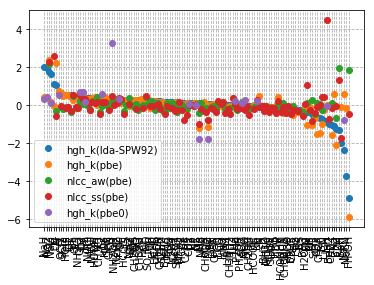

Study: hgh_k(pbe0)                    #--------------------
          Total Number of Molecules: 20
          MRE: 0.19177695207727735 +/- 0.9741849129508804
          RMSRE: 0.9928819889438848 +/- 1.2127448844508026
          There are 4 outliers: ['Mg', 'Mg2', 'NaCl', 'O3']
 
Study: nlcc_ss(pbe)                    #--------------------
          Total Number of Molecules: 105
          MRE: -0.011409103186098547 +/- 0.6829173758464635
          RMSRE: 0.683012671821344 +/- 1.5648148028506295
          There are 7 outliers: ['BeH', 'Mg', 'BN', 'C2H', 'HO2', 'Li', 'LiH']
 
Study: nlcc_aw(pbe)                    #--------------------
          Total Number of Molecules: 109
          MRE: 0.0006648808002810914 +/- 0.4025160749063986
          RMSRE: 0.4025166240349982 +/- 0.8263382217343754
          There are 4 outliers: ['Mg2', 'FH-OH', 'C2H', 'HO2']
 
Study: hgh_k(pbe)                    #--------------------
          Total Number of Molecules: 126
          MRE: 0.00827751462742532

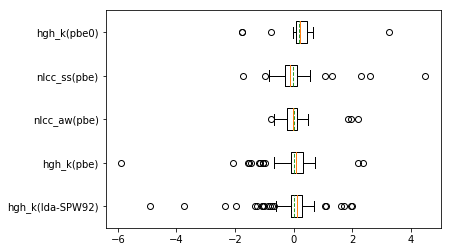

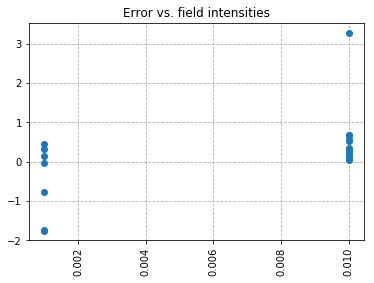

In [29]:
comparison_of_data()

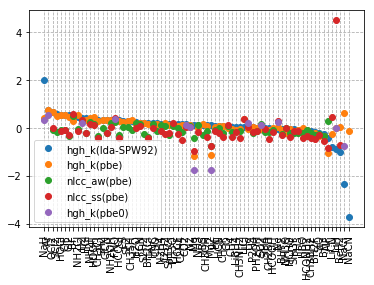

Study: hgh_k(pbe0)                    #--------------------
          Total Number of Molecules: 13
          MRE: -0.1739125283923317 +/- 0.7340343944607762
          RMSRE: 0.7543553935534709 +/- 0.7133202707374467
          There are 3 outliers: ['Mg', 'Mg2', 'NaCl']
 
Study: nlcc_ss(pbe)                    #--------------------
          Total Number of Molecules: 61
          MRE: -0.10602744430297319 +/- 0.667155002841132
          RMSRE: 0.6755276580284266 +/- 1.8981874055207513
          There are 2 outliers: ['Mg', 'LiH']
 
Study: nlcc_aw(pbe)                    #--------------------
          Total Number of Molecules: 63
          MRE: -0.09054384255324702 +/- 0.21075744538999042
          RMSRE: 0.2293837139197593 +/- 0.17431516581321704
          There are 1 outliers: ['Mg2']
 
Study: hgh_k(pbe)                    #--------------------
          Total Number of Molecules: 74
          MRE: 0.07967680671901209 +/- 0.3402625612411544
          RMSRE: 0.34946674249680637 +/- 

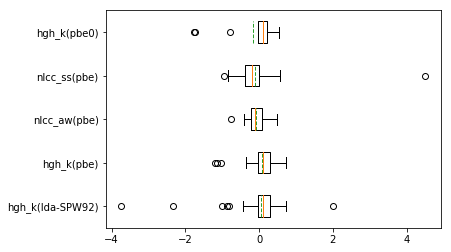

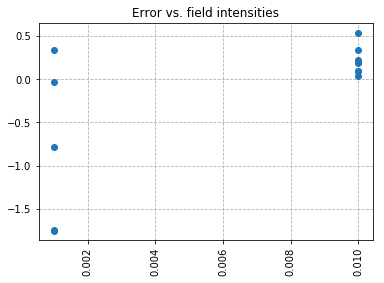

In [28]:
comparison_of_data(restrict_to=closed_shell)

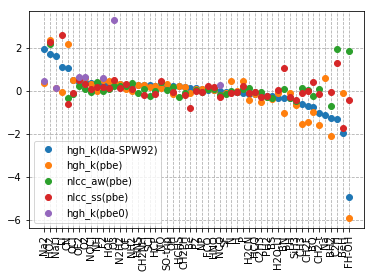

Study: hgh_k(pbe0)                    #--------------------
          Total Number of Molecules: 7
          MRE: 0.8709145586636939 +/- 1.0006548514958233
          RMSRE: 1.3265754031771075 +/- 1.3847329686644716
          There are 1 outliers: ['O3']
 
Study: nlcc_ss(pbe)                    #--------------------
          Total Number of Molecules: 44
          MRE: 0.1197663242713868 +/- 0.68283222228609
          RMSRE: 0.6932559528930416 +/- 0.9637239407116671
          There are 6 outliers: ['BeH', 'Be', 'BN', 'C2H', 'HO2', 'Li']
 
Study: nlcc_aw(pbe)                    #--------------------
          Total Number of Molecules: 46
          MRE: 0.12558117582793918 +/- 0.5441352720944277
          RMSRE: 0.5584387397554047 +/- 0.8958026724544939
          There are 4 outliers: ['BH2', 'FH-OH', 'C2H', 'HO2']
 
Study: hgh_k(pbe)                    #--------------------
          Total Number of Molecules: 52
          MRE: -0.09332917027214044 +/- 1.0950018526877485
          RMSR

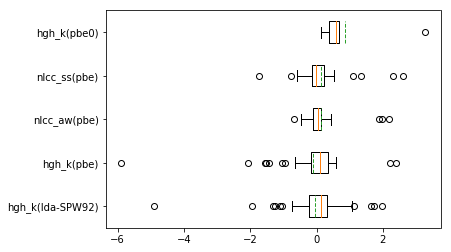

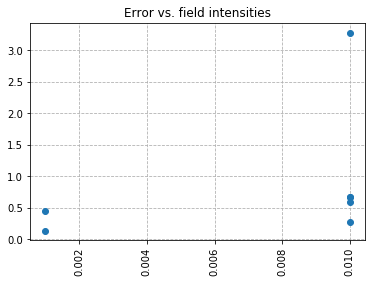

In [30]:
comparison_of_data(restrict_to=open_shell)